<a href="https://colab.research.google.com/github/yexf308/AdvancedMachineLearning/blob/main/Fast_KNN_LSH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import Image

reference [Emily Fox course](https://courses.cs.washington.edu/courses/cse547) and [her open course](https://www.coursera.org/learn/ml-clustering-and-retrieval). 

$\def\m#1{\mathbf{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
# Locality	Sensitive	Hashing	(LSH)

K-d trees are very helpful, but it is non-trivial	to	implement	efficiently and can only handle dimension $d\le 20$. In fact, it could be shown that under some conditions
that you visit at least $2^d$ nodes to get a good approximation of nearest neighbour. 



In practice, we only need to find **approximate neighbours**. It is okay for many applications, especially in big data situation. 

## Hash table
One idea works extremely well, is to use a hash table. Suppose we have a “hash”
function $g$ which of the form $g: \c{X}\rightarrow \{0,1\}^k$, e.g. it maps data to binary strings.  Suppose this function is cheap to compute, which can often be achieved easily. 

Hopefully we can find neighbours that falls into the same bin(hash value) of the query point. 

But by the design, for a query point $\m{x}$, 
$$ \mb{P}(g(\m{x})= g(\m{x}'))=\frac{1}{2^k}$$
for any $\m{x}'\in \c{X}$. Even if $g(\m{x})\approx g(\m{x}')$, it doesn't immediately imply $d(\m{x}, \m{x}')$ is small.  

- It is challenging to find good hashing function since points close together get split into separate bins. 

- Large computational cost: bins might contain many points, so still
searching over large set for each NN query.

- But can serve most of purpose here. 


### Example
<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/lsh1.png?raw=true" width="400" />
<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/lsh2.png?raw=true" width="400" />

<br>
<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/lsh3.png?raw=true" width="400" />
<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/lsh4.png?raw=true" width="400" />

## Locality	Sensitive	Hashing	
A	LSH	function $h$ satisfies	(for example), for some distance function $d$, for $r>0$ and $\alpha>1$, 

- If $d(\m{x}, \m{x}')< r $, then $\mb{P}(h(\m{x})=h(\m{x}'))$ is high (with probability at least $P_{1}$).

- If $d(\m{x}, \m{x}')> \alpha \cdot r$, then $\mb{P}(h(\m{x})=h(\m{x}'))$ is low (with probability at most $P_{2}$).

- (in	between,	not	sure	about	probability)	

<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/lsh5.png?raw=true" width="400" />

How to find LSH function with low cost?
**Random Projection!!**




### Random projection
- Pick	$d$ indepdent Gaussian random	vectors $\{\m{v}^{(i)}\}_{i=1}^d$, i.e., $v_j^{(i)} \sim N(0,1)$.

- The LSH $h$ function is 
$$h(\m{x})=\begin{bmatrix}\m{x} \m{v}^{(1)},  \m{x} \m{v}^{(2)} ,\cdots, \m{x} \m{v}^{(d)} \end{bmatrix}\in \mb{R}^d. $$

- From HW, we know $\m{x}\cdot (\m{x'})^\top \approx h(\m{x}) \cdot (h(\m{x'}))^\top$ with high probability. So we can use cosine similarity here!
 We only need about $O(\frac{\log(N)}{\epsilon^2})$ to approximate the inner product within $\epsilon$. 

- But all sparsity in $\m{x}$ is lost. Because $\m{v}^{(i)}$ is dense, then $h(\m{x})$ is also dense with high probability, even when $\m{x}$ is sparse. 

### Sparse random projection
Step 0: Pick $d$ such that $N/2^d$ is smallish. 


Step 1: Transform to binary vector. 

- Simple 0/1 projection
$$h_i(\m{x})=\begin{cases}1 & \text{if } \text{sign}(\m{x}\m{v}^{(i)})\ge 0 \\ 0 & \text{if } \text{sign}(\m{x}\m{v}^{(i)})< 0\end{cases} $$

- Now	each	vector	is	approximated	by	a	bit-vector, like 
$$ h(\m{x})=[1, 0, 1, \dots, 1]$$
Each bit-vector can be turned into an integer. There are total $2^d$ bins. 

- Approximation for cosine similarity: 
$$ \text{similarity}=\frac{\m{x}(\m{x'})^\top}{\|\m{x}\| \|\m{x'}\|}=\cos(\theta_{\m{x}\m{x'}}) \approx \cos\left( \frac{\pi}{d}\text{HammDist}(h(\m{x}), h(\m{x'}))\right)$$


<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/lsh6.png?raw=true" width="400" />

Step 2: If we use $h(\m{x})$ as index in the hashing table, very similar elements fall into the same bin. 

- When cosine similarity is high, $\theta_{\m{x}\m{x'}}\approx 0$ and $\text{HammDist}(h(\m{x}), h(\m{x'}))\approx 0$. Then $\m{x}, \m{x'}$ are in the same bin or in two different bins with very close Hamming distances. 

Step 3: Simple	neighbor	finding	with	LSH

- For	bins	$b$	of	increasing	hamming	distance	to $h(\m{x})$, look for nearest neighbours of $\m{x}$ in bin $b$.


- For example, if $h(\m{x})=[0,1,1,0]$, you should first look for $\m{x}'$ in the same bin as the query point $\m{x}$. Then check the bins that are one hamming distance away, such as $[1,1,1,0]$. Is it actually efficient?


## Multiple table method

Assume $\delta$ is the probability that the random hyperplane split the query point and its nearest neighbor, which are $\theta$ apart.


### First method: single hash table + 1 bit off
Pick two random hyperplanes and search
bins 1 bit off from query. 

Search 3 bins and do not
find NN with probability $\delta^2$.

<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/lsh7.png?raw=true" width="300" />

### Second method: multiple hash table + 0 bit off
Repeat two hyperplane binning three times, but search
only query bin per table. 

<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/lsh8.png?raw=true" width="500" />

What is chance
that query pt
and NN are split
in all three tables? 

For each table, Probability NN 
in different bin is $1-(1-\delta)^2 =2\delta -\delta^2$. 

Note $1-\delta$ is probability that one random line doesn't split the query and NN. $(1-\delta)^2$ is probability that two independent random lines don't split the query and NN. 


Probability NN 
in different bin in
all 3 tables is $(2\delta -\delta^2)^3$

### Summary for both methods

<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/lsh9.png?raw=true" width="400" />

<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/lsh10.png?raw=true" width="400" />

So multiple hash table + 0 bit off is the better choice!


### Extended to $h$ lines 

- Single hash table + 1 bit off: Search h+1 bins and do not find NN
with probability is $1-(1-\delta)^h-h\delta(1-\delta)^{h-1} $


-  Multiple hash table + 0 bit off: Probability NN is
in different bin in
all $h+1$ tables: $(1-(1-\delta)^h)^{h+1}$. 

# Example: wikipedia data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os,sys
os.chdir("/content/drive/My Drive")

nb_path = '/content/notebooks'
sys.path.insert(0,nb_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --target=$nb_path turicreate


In [3]:
from __future__ import print_function # to conform python 2.x print to python 3.x
import numpy as np
import turicreate
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances
import time
from copy import copy
import matplotlib.pyplot as plt
%matplotlib inline

'''compute norm of a sparse vector
   Thanks to: Jaiyam Sharma'''
def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return(norm)

## Data preparation: Load in the Wikipedia dataset
The data is in: https://drive.google.com/file/d/1mdfgBObzQ51wXZJc-z0DJKTrf8OguWBv/view?usp=sharing

Once you open the link in the brower, make sure you click the "Add shortcut to Drive" and now your google drive should show up the zip file.  Then you run the following code to link colab to your google drive.

In [ ]:
!unzip people_wiki.sframe.zip

In [4]:
wiki = turicreate.SFrame('people_wiki.sframe/')
wiki = wiki.add_row_number()

## Extract TF-IDF matrix
We first use Turi Create to compute a TF-IDF representation for each document.

In [5]:
wiki['tf_idf'] = turicreate.text_analytics.tf_idf(wiki['text'])
wiki.head()

id,URI,name,text,tf_idf
0,<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...,"{'melbourne':3.8914310119380633, ..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...,"{'time':1.3253342074200498, ..."
2,<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...,"{'society':2.4448047262085693, ..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...,"{'kurdlawitzpreis':10.986495389225194, ..."
4,<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...,"{'curtis':5.299520032885375, ..."
5,<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...,"{'asses':9.600201028105303, 's ..."
6,<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...,"{'streamz':10.986495389225194, ..."
7,<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...,"{'concordia':6.250296940830698, ..."
8,<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...,"{'heavies':8.907053847545358, 'n ..."
9,<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...,"{'2002':1.8753125887822302, ..."


In [6]:
wiki[0]['text']

'digby morrell born 10 october 1979 is a former australian rules footballer who played with the kangaroos and carlton in the australian football league aflfrom western australia morrell played his early senior football for west perth his 44game senior career for the falcons spanned 19982000 and he was the clubs leading goalkicker in 2000 at the age of 21 morrell was recruited to the australian football league by the kangaroos football club with its third round selection in the 2001 afl rookie draft as a forward he twice kicked five goals during his time with the kangaroos the first was in a losing cause against sydney in 2002 and the other the following season in a drawn game against brisbaneafter the 2003 season morrell was traded along with david teague to the carlton football club in exchange for corey mckernan he played 32 games for the blues before being delisted at the end of 2005 he continued to play victorian football league vfl football with the northern bullants carltons vfla

We will use sparse matrices. Sparse matrices are matrices) that have a small number of nonzero entries. A good data structure for sparse matrices would only store the nonzero entries to save space and speed up computation. SciPy provides a highly-optimized library for sparse matrices. Many matrix operations available for NumPy arrays are also available for SciPy sparse matrices.We first convert the TF-IDF column (in dictionary format) into the SciPy sparse matrix format.

In [7]:
def sframe_to_scipy(x, column_name):
    '''
    Convert a dictionary column of an SFrame into a sparse matrix format where
    each (row_id, column_id, value) triple corresponds to the value of
    x[row_id][column_id], where column_id is a key in the dictionary.
       
    Example
    >>> sparse_matrix, map_key_to_index = sframe_to_scipy(sframe, column_name)
    '''
    assert type(x[column_name][0]) == dict, \
        'The chosen column must be dict type, representing sparse data.'
    
    # Stack will transform x to have a row for each unique (row, key) pair.
    x = x.stack(column_name, ['feature', 'value'])
    
    # Map feature words to integers 
    unique_words = sorted(x['feature'].unique())
    mapping = {word:i for i, word in enumerate(unique_words)}
    x['feature_id'] = x['feature'].apply(lambda x: mapping[x])
    
    # Create numpy arrays that contain the data for the sparse matrix.
    row_id = np.array(x['id'])
    col_id = np.array(x['feature_id'])
    data = np.array(x['value'])
    
    width = x['id'].max() + 1
    height = x['feature_id'].max() + 1
    
    # Create a sparse matrix.
    mat = csr_matrix((data, (row_id, col_id)), shape=(width, height))
    return mat, mapping

In [8]:
%%time
corpus, mapping = sframe_to_scipy(wiki, 'tf_idf')

CPU times: user 2min 18s, sys: 7.51 s, total: 2min 26s
Wall time: 1min 58s


In [9]:
print(corpus.shape)

(59071, 547979)


## Train LSH model

### Step 1:
generate a collection of random vectors from the standard Gaussian distribution.

We now generate random vectors of the same dimensionality as our vocubulary size (547979). Each vector can be used to compute one bit in the bin encoding. We generate 16 vectors, leading to a 16-bit encoding of the bin index for each document.

In [10]:
def generate_random_vectors(dim, n_vectors):
    return np.random.randn(dim, n_vectors)

In [11]:
# Generate 16 random vectors of dimension 547979
np.random.seed(0)
n_vectors = 16
random_vectors = generate_random_vectors(corpus.shape[1], n_vectors)
random_vectors.shape

(547979, 16)

### Step 2: 
partition data points into bins.

We'd like to decide which bin document 0 should go. Since 16 random vectors were generated in the previous cell, we have 16 bits to represent the bin index. The first bit is given by the sign of the dot product between the first random vector and the document's TF-IDF vector.

In [12]:
sample = corpus[0] # vector of tf-idf values for document 0
# first bit
print(sample.dot(random_vectors[:,0]) >= 0) # True if positive sign; False if negative sign

# all bits
bin_indices_bits = sample.dot(random_vectors) >= 0 # should return an array of 16 True/False bits
print(bin_indices_bits)

bin_indices_bits_binary = np.array(sample.dot(random_vectors) >= 0, dtype=int) # display index bits in 0/1's
print(bin_indices_bits_binary)

[ True]
[[ True False False False  True False  True False  True  True  True False
   True  True False  True]]
[[1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1]]


All documents that obtain exactly this vector will be assigned to the same bin. We'd like to repeat the identical operation on all documents in the Wikipedia dataset and compute the corresponding bin indices

In [13]:
%%time
corpus.dot(random_vectors) >= 0 # compute bit indices of ALL documents

CPU times: user 271 ms, sys: 0 ns, total: 271 ms
Wall time: 272 ms


array([[ True, False, False, ...,  True, False,  True],
       [False, False, False, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False,  True],
       [ True,  True, False, ...,  True,  True, False],
       [ True,  True,  True, ...,  True, False,  True]])

To make it convenient to refer to individual bins, we convert each binary bin index into a single integer: 
```
Bin index                      integer
[0,0,0,0,0,0,0,0,0,0,0,0]   => 0
[0,0,0,0,0,0,0,0,0,0,0,1]   => 1
[0,0,0,0,0,0,0,0,0,0,1,0]   => 2
[0,0,0,0,0,0,0,0,0,0,1,1]   => 3
...
[1,1,1,1,1,1,1,1,1,1,0,0]   => 65532
[1,1,1,1,1,1,1,1,1,1,0,1]   => 65533
[1,1,1,1,1,1,1,1,1,1,1,0]   => 65534
[1,1,1,1,1,1,1,1,1,1,1,1]   => 65535 (= 2^16-1)
```

By the [rules of binary number representation](https://en.wikipedia.org/wiki/Binary_number#Decimal), we just need to compute the dot product between the document vector and the vector consisting of powers of 2:

In [14]:
index_bits = (sample.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print(index_bits)
print(powers_of_two)
print(index_bits.dot(powers_of_two))

[[ True False False False  True False  True False  True  True  True False
   True  True False  True]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[35565]


This following array gives us the integer index of the bins for all documents.

In [17]:
index_bits = corpus.dot(random_vectors) >= 0
print(index_bits.dot(powers_of_two))

[35565  2277 61191 ...  2729 50638 63741]


Fetch the list of document ids associated with the bin; if no list yet exists for this bin, assign the bin an empty list. Add the document id to the end of the list.

In [18]:
from collections import defaultdict 

def train_lsh(data, n_vectors, seed=None):    
    if seed is not None:
        np.random.seed(seed)

    dim = data.shape[1]
    random_vectors = generate_random_vectors(dim, n_vectors)  

    # Partition data points into bins,
    # and encode bin index bits into integers
    bin_indices_bits = data.dot(random_vectors) >= 0
    powers_of_two = 1 << np.arange(n_vectors - 1, -1, step=-1)
    bin_indices = bin_indices_bits.dot(powers_of_two)

    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i
    table = defaultdict(list)
    for idx, bin_index in enumerate(bin_indices):
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        # data_index: document ids
        # append() will add a list of document ids to table dict() with key as bin_index
        table[bin_index].append(idx)
    
    # Note that we're storing the bin_indices here
    # so we can do some ad-hoc checking with it,
    # this isn't actually required
    model = {'data': data,
             'table': table,
             'random_vectors': random_vectors,
             'bin_indices': bin_indices,
             'bin_indices_bits': bin_indices_bits}
    return model

In [19]:
def compare_bits(model, id_1, id_2):
    bits1 = model['bin_indices_bits'][id_1]
    bits2 = model['bin_indices_bits'][id_2]
    print('Number of agreed bits: ', np.sum(bits1 == bits2))
    return np.sum(bits1 == bits2)

In [24]:
model = train_lsh(corpus, 16, seed=475)
obama_id = wiki[wiki['name'] == 'Barack Obama']['id'][0]
biden_id = wiki[wiki['name'] == 'Joe Biden']['id'][0]
print(f'obama_id is {obama_id}')
print(f'biden_id is {biden_id}')
similariy = compare_bits(model, obama_id, biden_id)

obama_id is 35817
biden_id is 24478
Number of agreed bits:  15


In [ ]:
model['table']

## Inspect bins
After generating our LSH model, let's examine the generated bins to get a deeper understanding of them. Here, we will look at these similar products' bins to see if the result matches intuition. Remember the idea behind LSH is that similar data points will tend to fall into nearby bins.

In [119]:
# This function will help us get similar items, given the id
# this is brute force search 
def get_similarity_items(X_tfidf, item_id, topn=5, verbose=True):
    """
    Get the top similar items for a given item id.
    The similarity measure here is based on cosine distance.
    """
    query = X_tfidf[item_id]
    scores = pairwise_distances(X_tfidf, query, metric='cosine').flatten()
    best = np.argpartition(scores, topn)[:topn]
    similar_items = sorted(zip(best, scores[best]), key=lambda x: x[1])
    similar_item_ids = [similar_item for similar_item, _ in similar_items]
    if verbose:
      print("Similar items to id: {}".format(item_id))
      for _id in similar_item_ids:
          print(wiki[_id]['name'])
      print('\n')

    return similar_item_ids

Let us look at some documents and see which bins they fall into.

In [102]:
similar_item_ids = get_similarity_items(corpus, obama_id, topn=5)
print(similar_item_ids)

Similar items to id: 35817
Barack Obama
Joe Biden
Samantha Power
Hillary Rodham Clinton
Eric Stern (politician)


[35817, 24478, 38376, 57108, 38714]


In [103]:
for i in similar_item_ids:
  name = {wiki[i]['name']}
  print('Barack Obama and', name)
  similariy = compare_bits(model, obama_id, i)
  print('\n')


Barack Obama and {'Barack Obama'}
Number of agreed bits:  16


Barack Obama and {'Joe Biden'}
Number of agreed bits:  15


Barack Obama and {'Samantha Power'}
Number of agreed bits:  13


Barack Obama and {'Hillary Rodham Clinton'}
Number of agreed bits:  10


Barack Obama and {'Eric Stern (politician)'}
Number of agreed bits:  11




Compare the result with a former British diplomat

In [35]:
jones_id = wiki[wiki['name']=='Wynn Normington Hugh-Jones']['id'][0]
compare_bits(model, obama_id, jones_id)

Number of agreed bits:  8


8

In [36]:
model['table'][model['bin_indices'][obama_id]]

[35817, 54743]

How about the documents in the same bin as Barack Obama? Are they necessarily more similar to Obama than Biden? Let's look at which documents are in the same bin as the Barack Obama article.

In [40]:
wiki[54743]['text']

'radovan erjav born 2 december 1968 is a slovenian conservative politician between 2007 and 2008 he served as minister of transport during the second term under janez jana he in 2012 served as minister of economic development and technology which he left since jana was ignoring the 20122013 investigation report on the parliamentary parties leaders by commission for the prevention of corruption of the republic of slovenia since 2009 he has been the chairman of the slovenian peoples party and a deputy in the national assemblyerjav was born in maribor slovenia then part of the socialist federal republic of yugoslavia he spent his childhood in the prekmurje region of eastern slovenia he attended a bilingual slovenehungarian primary school in lendava and high school in murska sobota in 1988 he enrolled to the university of maribor graduating from chemical engineering in 1993 in 1996 he continued his studies and in 2003 he received his masters degree in chemical engineeringafter having finis

In [38]:
compare_bits(model, obama_id, 54743)

Number of agreed bits:  16


16

**In summary**, similar data points will in general _tend to_ fall into _nearby_ bins, but that's all we can say about LSH. In a high-dimensional space such as text features, we often get unlucky with our selection of only a few random vectors such that dissimilar data points go into the same bin while similar data points fall into different bins. **Given a query document, we must consider all documents in the nearby bins and sort them according to their actual distances from the query.**

## Query the LSH model

-  Let $L$ be the bit representation of the bin that contains the query documents.
- Consider all documents in bin $L$.
- Consider documents in the bins whose bit representation differs from $L$ by 1 bit.
- Consider documents in the bins whose bit representation differs from $L$ by 2 bits.


To obtain candidate bins that differ from the query bin by some number of bits, we use `itertools.combinations`, which produces all possible subsets of a given list. See [this documentation](https://docs.python.org/3/library/itertools.html#itertools.combinations) for details.

1. Decide on the search radius r. This will determine the number of different bits between the two vectors.
2. For each subset (n_1, n_2, ..., n_r) of the list [0, 1, 2, ..., num_vector-1], do the following:
   * Flip the bits (n_1, n_2, ..., n_r) of the query bin to produce a new bit vector.
   * Fetch the list of documents belonging to the bin indexed by the new bit vector.
   * Add those documents to the candidate set.

In [ ]:
from itertools import combinations
num_vector = 16
search_radius = 2

for diff in combinations(range(num_vector), search_radius):
    print(diff)

In [46]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = not alternate_bits[i]
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        if nearby_bin in table:
            more_docs = table[nearby_bin] # Get all document_ids of the bin
            candidate_set.update(more_docs) # Update candidate_set with the documents in this bin.
            
    return candidate_set

In [50]:
obama_bin_index = model['bin_indices_bits'][obama_id] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
print('List of documents in the same bin as Obama: {}'.format(candidate_set))

List of documents in the same bin as Obama: {35817, 54743}


In [51]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
print('List of documents in the one bit off from Obama: {}'.format(candidate_set))

List of documents in the one bit off from Obama: {42243, 28804, 1810, 48919, 24478, 31010, 7331, 23716, 51108, 48040, 36266, 33200, 25023, 23617, 54743, 34910, 35817, 34159, 14451, 23926, 39032, 12028, 43775}


Now we have a function that can return all the candidates from neighboring bins. Next we write a function to collect all candidates and compute their true distance to the query.

In [105]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = turicreate.SFrame({'id':candidate_set})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.topk('distance', k, reverse=True), len(candidate_set)

Let's try it out with Obama:

In [106]:
query(corpus[obama_id,:], model, k=5, max_search_radius=3)

(Columns:
 	id	int
 	distance	float
 
 Rows: 5
 
 Data:
 +-------+------------------------+
 |   id  |        distance        |
 +-------+------------------------+
 | 35817 | 1.1102230246251565e-16 |
 | 24478 |   0.703138676733575    |
 | 38376 |   0.7429819023278823   |
 |  4032 |   0.8145547486714284   |
 | 43155 |   0.8408390074837325   |
 +-------+------------------------+
 [5 rows x 2 columns], 771)

To identify the documents, it's helpful to join this table with the Wikipedia table:

In [107]:
query(corpus[obama_id,:], model, k=5, max_search_radius=3)[0].join(wiki[['id', 'name']], on='id').sort('distance')

id,distance,name
35817,1.1102230246251565e-16,Barack Obama
24478,0.703138676733575,Joe Biden
38376,0.7429819023278823,Samantha Power
4032,0.8145547486714284,Kenneth D. Thompson
43155,0.8408390074837325,Goodwin Liu


In [56]:
wiki[wiki['name']=='Barack Obama']

id,URI,name,text,tf_idf
35817,<http://dbpedia.org/resource/Barack_Obama> ...,Barack Obama,barack hussein obama iibrk husen bm born august ...,"{'normalize':10.293348208665249, ..."


In [109]:
%%time
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start=time.time()
    result, num_candidates = query(corpus[35817,:], model, k=5,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start
    
    print('Radius:', max_search_radius)
    print(result.join(wiki[['id', 'name']], on='id').sort('distance'))
    
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)


Radius: 0
+-------+------------------------+---------------------+
|   id  |        distance        |         name        |
+-------+------------------------+---------------------+
| 35817 | 1.1102230246251565e-16 |     Barack Obama    |
| 54743 |    0.97334561058472    | Radovan %C5%BDerjav |
+-------+------------------------+---------------------+
[2 rows x 3 columns]

Radius: 1
+-------+------------------------+------------------------------+
|   id  |        distance        |             name             |
+-------+------------------------+------------------------------+
| 35817 | 1.1102230246251565e-16 |         Barack Obama         |
| 24478 |   0.703138676733575    |          Joe Biden           |
| 34159 |   0.9430865736846581   |       Jennifer Hudson        |
| 23926 |   0.9608039657958866   | Se%C3%A1n Power (politician) |
| 36266 |   0.9615994281067699   |         Ralph Weber          |
+-------+------------------------+------------------------------+
[5 rows x 3 columns]



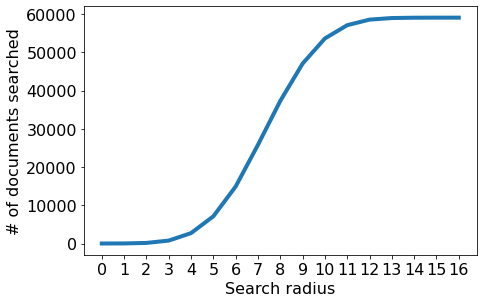

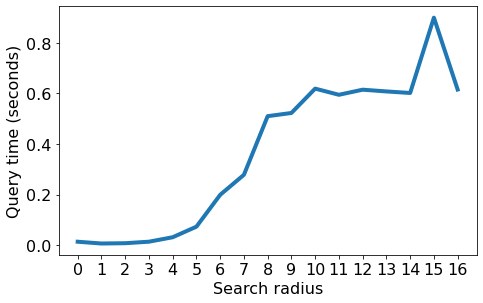

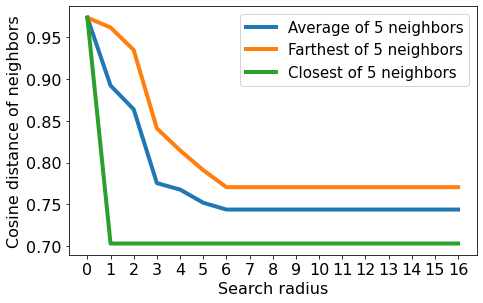

In [115]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xticks(np.arange(17))
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xticks(np.arange(17))
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 5 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 5 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 5 neighbors')
plt.xticks(np.arange(17))
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Quality metric for neighbors
The above analysis is limited by the fact that it was run with a single query, namely Barack Obama. We should repeat the analysis for the entirety of data. Iterating over all documents would take a long time, so let us randomly choose 10 documents for our analysis.

For each document, we first compute the true 25 nearest neighbors, and then run LSH multiple times. We look at two metrics:

Precision@10: How many of the 10 neighbors given by LSH are among the true 25 nearest neighbors?
Average cosine distance of the neighbors from the query
Then we run LSH multiple times with different search radii.

In [120]:
%%time
max_radius = 17
precision = {i:[] for i in range(max_radius)}
average_distance  = {i:[] for i in range(max_radius)}
query_time  = {i:[] for i in range(max_radius)}

num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(get_similarity_items(corpus, ix, topn=25, verbose=False))
    # set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors
    
    for r in range(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result['id']) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
CPU times: user 57.6 s, sys: 811 ms, total: 58.4 s
Wall time: 58.4 s


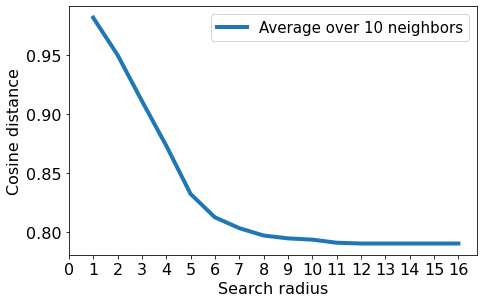

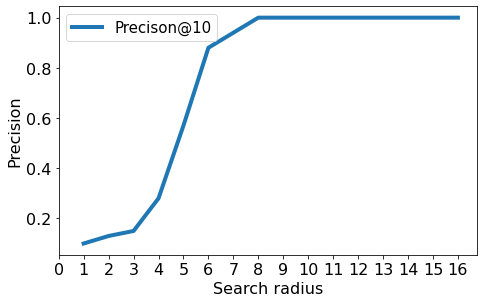

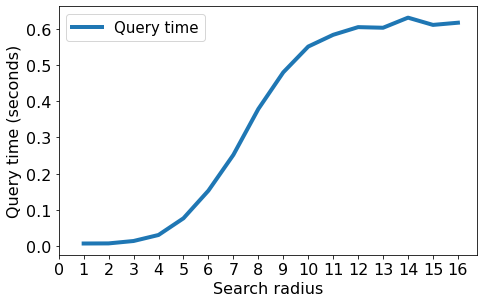

In [121]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in range(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.xticks(np.arange(17))
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in range(1,17)], linewidth=4, label='Precison@10')
plt.xticks(np.arange(17))
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in range(1,17)], linewidth=4, label='Query time')
plt.xticks(np.arange(17))
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Effect of number of random vectors

Let us now turn our focus to the remaining parameter: the number of random vectors. We run LSH with different number of random vectors, ranging from 5 to 20. We fix the search radius to 3.


In [122]:
precision = {i:[] for i in range(5,20)}
average_distance  = {i:[] for i in range(5,20)}
query_time = {i:[] for i in range(5,20)}
num_candidates_history = {i:[] for i in range(5,20)}
ground_truth = {}

num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(get_similarity_items(corpus, ix, topn=25, verbose=False))
    # Get the set of 25 true nearest neighbors

for num_vector in range(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result['id']) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


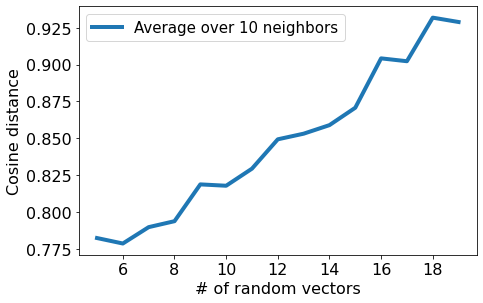

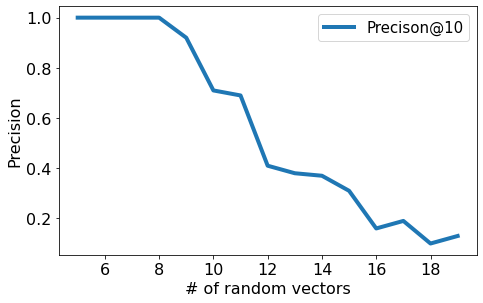

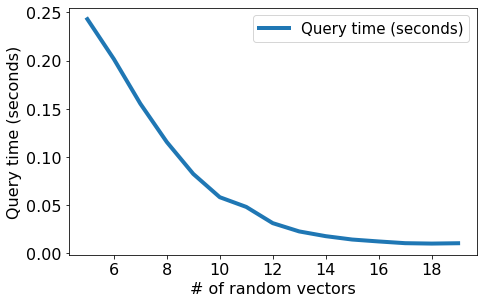

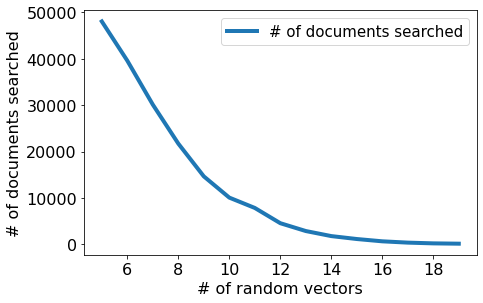

In [123]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in range(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in range(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in range(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in range(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

We see a similar trade-off between quality and performance: as the number of random vectors increases, the query time goes down as each bin contains fewer documents on average, but on average the neighbors are likewise placed farther from the query. On the other hand, when using a small enough number of random vectors, LSH becomes very similar brute-force search: Many documents appear in a single bin, so searching the query bin alone covers a lot of the corpus; then, including neighboring bins might result in searching all documents, just as in the brute-force approach.